In [1]:
###Import
import sys

#import geobayes_simple as gs
from matplotlib import pyplot as plt
from IPython.core.display import Image

%matplotlib inline
import pymc as pm
from pymc.Matplot import plot
import numpy as np
from IPython.core.pylabtools import figsize
figsize(10, 3)
import seaborn
seaborn.set_context(font_scale=2)
seaborn.set_style("white")

from pymc import graph

import scipy.optimize as sop
import scipy.stats as stats
import matplotlib.mlab as mlab

plt.rcParams.update({'font.size': 16})
plt.rc('xtick', labelsize=16) 
plt.rc('ytick', labelsize=16) 

In [2]:
#LOSS FUNCTIONS
estimates_s = np.arange(-3000,6000,5)

#weight factors
ov = 1.25
ov_b = 2
uv_b = 1.5

#risk parameters
risks_s = np.arange(0.5, 1.6, 0.25)

#risk neutral
def res_score_loss4(estimate_s, true_s):
        loss_s = np.zeros_like(true_s)
        underest = (estimate_s < true_s) 
        underest_bad = (estimate_s <= 0) & (true_s > 0)
        overest = (estimate_s > true_s) 
        overest_bad = (estimate_s > 0) & (true_s <= 0)
        loss_s[underest] = (true_s[underest] - estimate_s)
        loss_s[underest_bad] = (true_s[underest_bad] - estimate_s)*uv_b
        loss_s[overest] = (estimate_s - true_s[overest])*ov
        loss_s[overest_bad] = (estimate_s - true_s[overest_bad])*ov_b
        return loss_s

#including risk
def res_score_lossR(estimate_s, true_s, risk_s):
        loss_s = np.zeros_like(true_s)
        underest = (estimate_s < true_s) 
        underest_bad = (estimate_s <= 0) & (true_s > 0)
        overest = (estimate_s > true_s) 
        overest_bad = (estimate_s > 0) & (true_s <= 0)
        loss_s[underest] = (true_s[underest] - estimate_s)*(risk_s**-0.5)
        loss_s[underest_bad] = (true_s[underest_bad] - estimate_s)*(uv_b*(risk_s**-0.5))
        loss_s[overest] = (estimate_s - true_s[overest])*(ov*risk_s)
        loss_s[overest_bad] = (estimate_s - true_s[overest_bad])*(ov_b*risk_s)
        return loss_s

In [3]:
###Distributions for boundary locations
alpha = pm.Normal("alpha", -2000, 1./np.square(7.))
beta = pm.Normal("beta", -2050, 1./np.square(25))
gamma = pm.Normal("gamma", -2200, 1./np.square(45))

###Model
model = pm.Model([alpha, beta, gamma])
M = pm.MCMC(model)
M.sample(iter=5000)

 [-----------------100%-----------------] 5000 of 5000 complete in 0.2 sec

In [4]:
alpha_samples = M.trace('alpha')[:]
beta_samples = M.trace('beta')[:]
gamma_samples = M.trace('gamma')[:]

alpha_samples, alpha_samples_all = M.trace('alpha')[-80:], M.trace("alpha")[:]
beta_samples, beta_samples_all = M.trace('beta')[-80:], M.trace("beta")[:]
gamma_samples, gamma_samples_all = M.trace('gamma')[-80:], M.trace('gamma')[:]

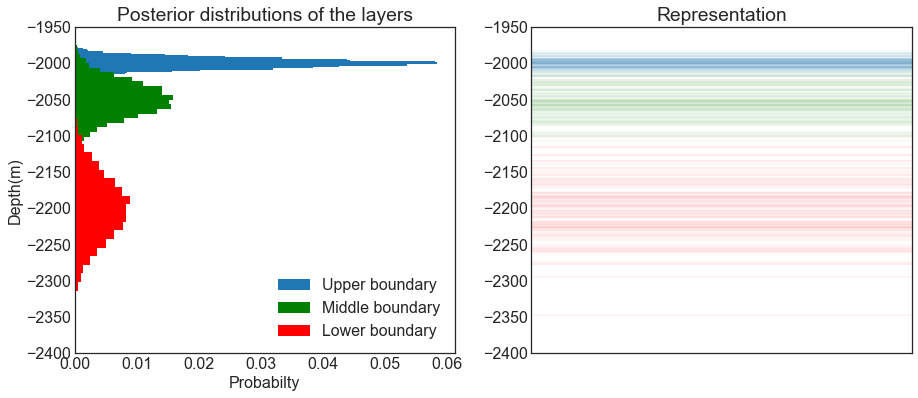

In [5]:
figsize(15,6)
fig, ax = plt.subplots(1, 2)

ax[0].hist(alpha_samples_all, histtype='stepfilled', bins=30, alpha=1,
    label="Upper boundary", normed=True,  orientation="horizontal")
ax[0].hist(beta_samples_all, histtype='stepfilled', bins=30, alpha=1,
    label="Middle boundary", normed=True, color = "g",  orientation="horizontal")
ax[0].hist(gamma_samples_all, histtype='stepfilled', bins=30, alpha=1,
 label="Lower boundary", normed=True, color = "r", orientation="horizontal")

ax[0].legend(loc = 0)
ax[0].set_title(r"""Posterior distributions of the layers""")
ax[0].set_ylabel("Depth(m)")
ax[0].set_ylim([-2400,-1950])
ax[0].set_xlabel("Probabilty")

ax[1].set_title("Representation")
ax[1].set_ylim([-2400,-1950])
ax[1].xaxis.set_visible(False)
for i in range(100):
    ax[1].axhline(alpha_samples_all[i], alpha = 0.05)
    ax[1].axhline(beta_samples_all[i], c = "g", alpha = 0.05)
    ax[1].axhline(gamma_samples_all[i],c = "r", alpha = 0.05)

In [6]:
seal_thickness = (alpha_samples_all - beta_samples_all)
reservoir_thickness = (beta_samples_all - gamma_samples_all)
reservoir_depth = beta_samples_all

th_v = 20 #value per meter reservoir thickness
dp_c = 1  #cost per meter depth
seal_to = 20 #Minimum treshold for seal to be safe

seal_top = alpha
res_top = beta
res_bottom = gamma

In [7]:
#MODEL 2: 3 parameter score modeling
@pm.deterministic
def res_thickness(res_top=res_top, res_bottom=res_bottom):
    return np.abs(res_top - res_bottom)

@pm.deterministic
def score_if_seal(res_thickness=res_thickness, res_depth=res_top, \
                  th_v=th_v, dp_c=dp_c):
    return (th_v * res_thickness + (dp_c * res_depth))

@pm.deterministic
def score_if_seal_fail(res_depth=res_top, dp_c=dp_c):
    return (dp_c * res_depth)

@pm.deterministic
def true_score(seal_top=seal_top, res_top=res_top,
                 dp_c=dp_c, res_depth=res_top, 
                 score_if_seal = score_if_seal, score_if_seal_fail=score_if_seal_fail):
    seal_th = seal_top - res_top
    seal_failure = seal_th < seal_to
    x = np.zeros_like(seal_top)
    x[~seal_failure] = score_if_seal[~seal_failure]
    x[seal_failure] = score_if_seal_fail[seal_failure]
    return x

model2 = pm.Model([true_score, res_thickness, score_if_seal, score_if_seal_fail, res_top, res_bottom, seal_top])

M2 = pm.MCMC(model2)
M2.sample(iter=5000)

 [-----------------100%-----------------] 5000 of 5000 complete in 0.4 sec

In [8]:
M2.trace("true_score")[:]
res_score = M2.trace("true_score")[:]

In [9]:
area_th = 10000

#Volumetric calculation
@pm.deterministic
def true_vol(seal_top=seal_top, res_top=res_top,
                 dp_c=dp_c, res_thickness=res_thickness):
    seal_th = seal_top - res_top
    seal_failure = seal_th < seal_to
    x = np.zeros_like(seal_top)
    x[~seal_failure] = res_thickness * area_th
    x[seal_failure] = 0
    return x

In [10]:
modelV1 = pm.Model([true_vol, res_thickness, res_top, res_bottom, seal_top])

MV1 = pm.MCMC(modelV1)
MV1.sample(iter=5000)

 [-----------------100%-----------------] 5000 of 5000 complete in 0.3 sec

In [11]:
MV1.trace("true_vol")[:]
res_vol1 = MV1.trace("true_vol")[:]

In [12]:
#Additional information, updating with likelihoods
std1 = 20
std2 = 200

@pm.stochastic
def layer_thickness1(value = 0, alpha = seal_top, beta = res_top):
    a = alpha-beta
    return pm.normal_like(a, 25., 1./np.square(std1))

@pm.stochastic
def layer_thickness2(value = 0,  beta = res_top, gamma = res_bottom):
    b = beta-gamma
    return pm.normal_like(b, 300., 1./np.square(std2))

model3 = pm.Model([alpha, beta, gamma, layer_thickness1, layer_thickness2])

M3 = pm.MCMC(model3)
M3.sample(iter=10000, burn = 1000)

 [-----------------100%-----------------] 10000 of 10000 complete in 1.3 sec

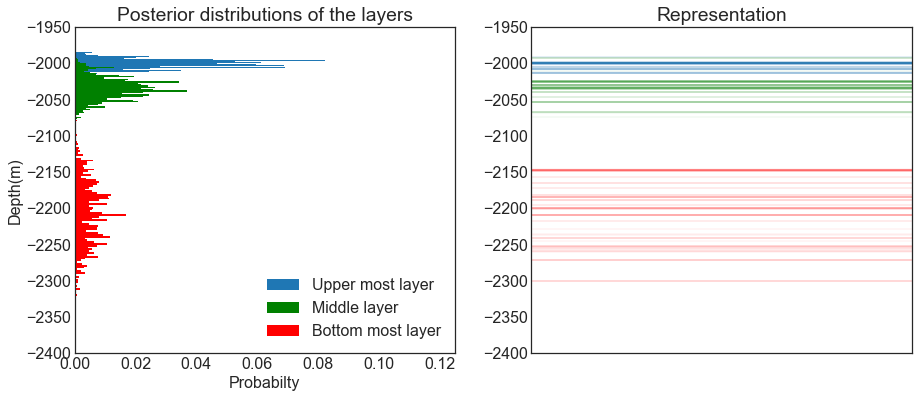

In [13]:
figsize(15,6)
fig, ax = plt.subplots(1, 2)
alpha_samples2 = M3.trace('alpha')[:]
beta_samples2 = M3.trace('beta')[:]
gamma_samples2 = M3.trace('gamma')[:]

alpha_samples2, alpha_samples_all2 = M3.trace('alpha')[-80:], M3.trace("alpha")[:]
beta_samples2, beta_samples_all2 = M3.trace('beta')[-80:], M3.trace("beta")[:]
gamma_samples2, gamma_samples_all2 = M3.trace('gamma')[-80:], M3.trace('gamma')[:]

ax[0].hist(alpha_samples_all2, histtype='stepfilled', bins=60, alpha=1,
    label="Upper most layer", normed=True,  orientation="horizontal")
ax[0].hist(beta_samples_all2, histtype='stepfilled', bins=60, alpha=1,
    label="Middle layer", normed=True, color = "g",  orientation="horizontal")
ax[0].hist(gamma_samples_all2, histtype='stepfilled', bins=120, alpha=1,
 label="Bottom most layer", normed=True, color = "r", orientation="horizontal")

ax[0].legend(loc = 0)
ax[0].set_title(r"""Posterior distributions of the layers""")
ax[0].set_ylabel("Depth(m)")
ax[0].set_xlabel("Probabilty")
ax[0].set_ylim([-2400,-1950])

ax[1].set_title("Representation")
ax[1].set_ylim([-2400,-1950])
ax[1].xaxis.set_visible(False)

for i in range(100):
    ax[1].axhline(alpha_samples_all2[-i], alpha = 0.05)
    ax[1].axhline(beta_samples_all2[-i], c = "g", alpha = 0.05)
    ax[1].axhline(gamma_samples_all2[-i],c = "r", alpha = 0.05)

C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:46: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:47: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:48: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


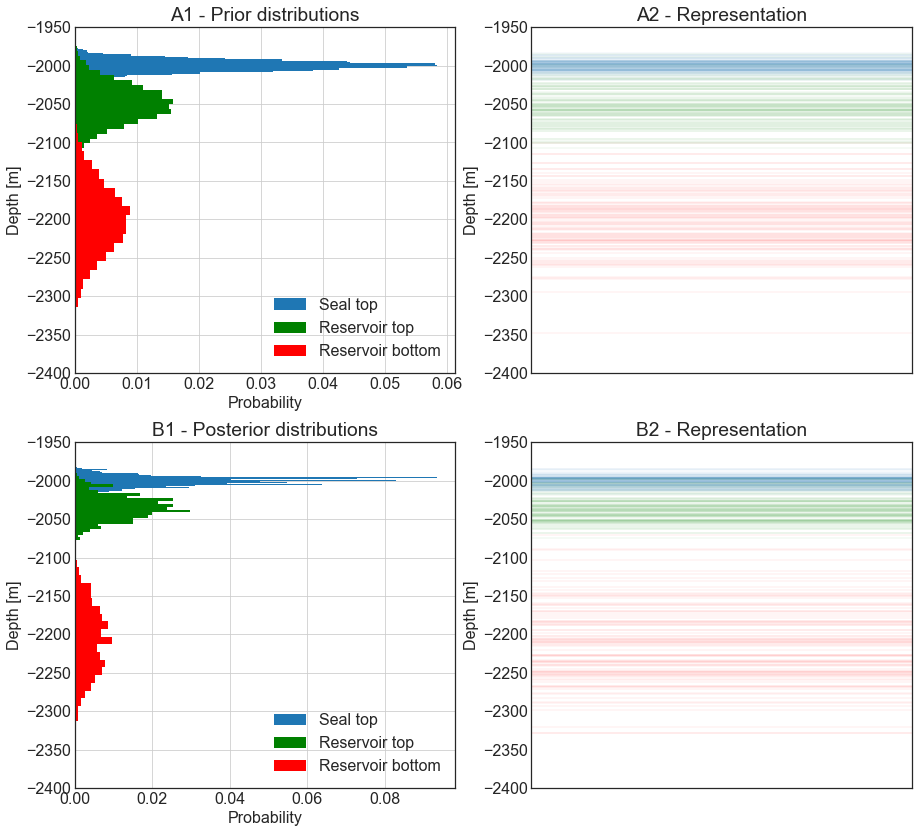

In [14]:
figsize(15,14)
fig, ax = plt.subplots(2, 2)

ax[0,0].hist(alpha_samples_all, histtype='stepfilled', bins=30, alpha=1,
    label="Seal top", normed=True,  orientation="horizontal")
ax[0,0].hist(beta_samples_all, histtype='stepfilled', bins=30, alpha=1,
    label="Reservoir top", normed=True, color = "g",  orientation="horizontal")
ax[0,0].hist(gamma_samples_all, histtype='stepfilled', bins=30, alpha=1,
 label="Reservoir bottom", normed=True, color = "r", orientation="horizontal")

ax[0,0].legend(loc = 0)
ax[0,0].set_title(r"""A1 - Prior distributions""")
ax[0,0].set_ylabel("Depth [m]")
ax[0,0].set_ylim([-2400,-1950])
ax[0,0].set_xlabel("Probability")
ax[0,0].grid()

ax[0,1].set_title("A2 - Representation")
ax[0,1].set_ylim([-2400,-1950])
ax[0,1].xaxis.set_visible(False)
ax[0,1].set_ylabel("Depth [m]")
for i in range(100):
    ax[0,1].axhline(alpha_samples_all[i], alpha = 0.05)
    ax[0,1].axhline(beta_samples_all[i], c = "g", alpha = 0.05)
    ax[0,1].axhline(gamma_samples_all[i],c = "r", alpha = 0.05)
    
ax[1,0].hist(alpha_samples_all2, histtype='stepfilled', bins=30, alpha=1,
    label="Seal top", normed=True,  orientation="horizontal")
ax[1,0].hist(beta_samples_all2, histtype='stepfilled', bins=30, alpha=1,
    label="Reservoir top", normed=True, color = "g",  orientation="horizontal")
ax[1,0].hist(gamma_samples_all2, histtype='stepfilled', bins=30, alpha=1,
 label="Reservoir bottom", normed=True, color = "r", orientation="horizontal")

ax[1,0].legend(loc = 4)
ax[1,0].set_title(r"""B1 - Posterior distributions""")
ax[1,0].set_ylabel("Depth [m]")
ax[1,0].set_ylim([-2400,-1950])
ax[1,0].set_xlabel("Probability")
ax[1,0].grid()

ax[1,1].set_title("B2 - Representation")
ax[1,1].set_ylim([-2400,-1950])
ax[1,1].xaxis.set_visible(False)
ax[1,1].set_ylabel("Depth [m]")
for i in np.linspace(0,9000 -1, 100):
    ax[1,1].axhline(alpha_samples_all2[i], alpha = 0.05)
    ax[1,1].axhline(beta_samples_all2[i], c = "g", alpha = 0.05)
    ax[1,1].axhline(gamma_samples_all2[i],c = "r", alpha = 0.05)    

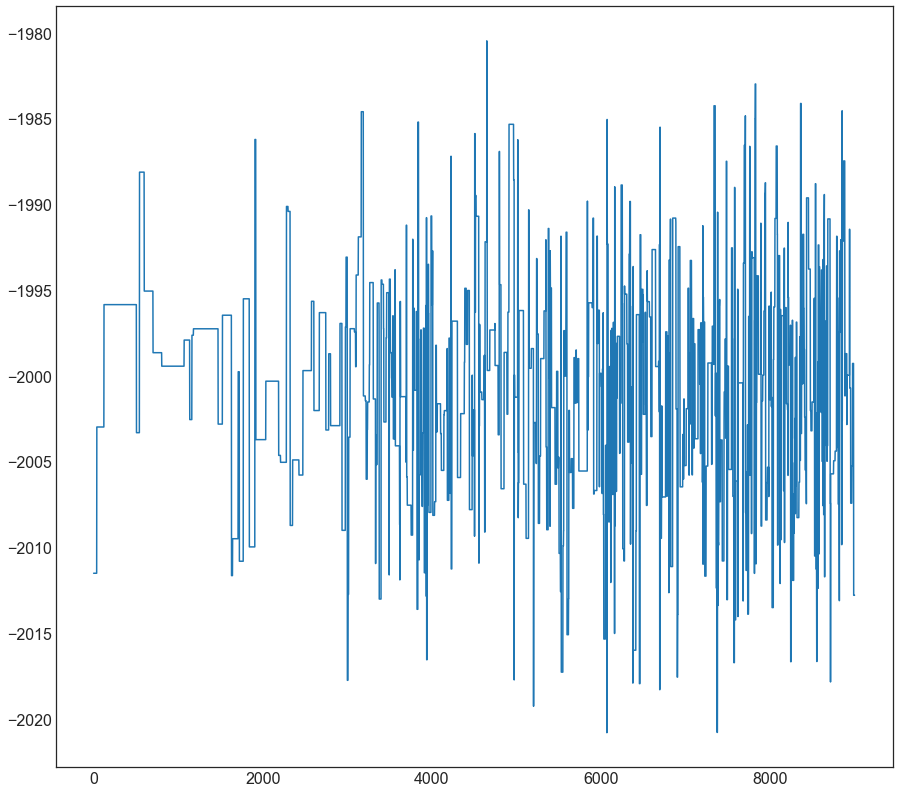

In [15]:
plt.plot(alpha_samples_all2)

In [16]:
model4 = pm.Model([true_score, score_if_seal, score_if_seal_fail, layer_thickness1, layer_thickness2, res_top, res_bottom, seal_top])

M4= pm.MCMC(model4)
M4.sample(iter=10000, burn=1000)

 [-----------------100%-----------------] 10000 of 10000 complete in 1.5 sec

In [17]:
res_score2 = M4.trace("true_score")[:]

Portion of cases in which the score is negative prior: 0.3004
Portion of cases in which the score is negative post: 0.256111111111
Mean of prior distribution: 488.4249555
Mean of posterior distribution: 624.960980877
Median of prior distribution: 655.773391424
Median of posterior distribution: 973.204519306


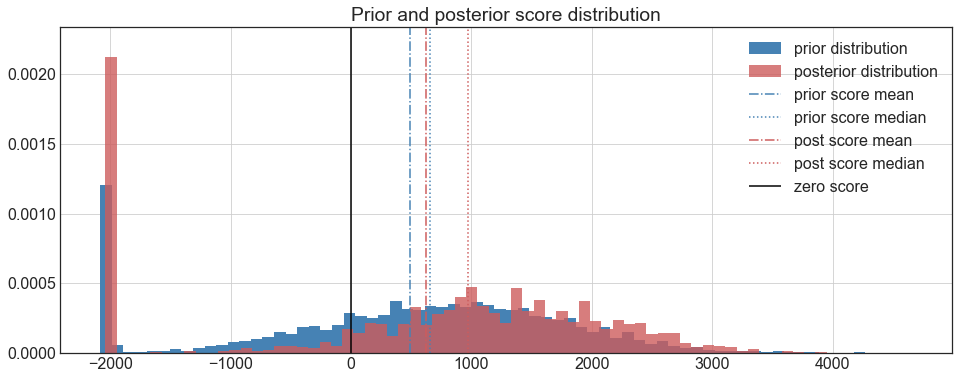

In [18]:
###Comparative figure of score before and after updating
figsize(16, 6)

_hist1 = plt.hist(res_score, bins=70, normed=True, histtype="stepfilled",label="prior distribution", color = "steelblue")

_hist2 = plt.hist(res_score2, bins=70, normed=True, histtype="stepfilled",label="posterior distribution", color = "indianred", alpha = 0.8)

plt.vlines(res_score.mean(), 0, 1.1 * np.max(_hist2[0]), label="prior score mean", linestyles="-.", color = "steelblue")
plt.vlines(np.median(res_score), 0, 1.1 * np.max(_hist2[0]), label="prior score median", linestyles=":", color = "steelblue")

plt.vlines(res_score2.mean(), 0, 1.1 * np.max(_hist2[0]), label="post score mean", linestyles="-.", color = "indianred")
plt.vlines(np.median(res_score2), 0, 1.1 * np.max(_hist2[0]), label="post score median", linestyles=":", color = "indianred")

plt.vlines(0, 0, 1.1 * np.max(_hist2[0]), label="zero score", linestyles="-")

plt.title("Prior and posterior score distribution")
plt.legend(loc="upper right");
plt.grid()
plt.ylim(0, 1.1 * np.max(_hist2[0]))

negative_cases1 = (res_score<0).sum()/5000
negative_cases2 = (res_score2<0).sum()/9000
print("Portion of cases in which the score is negative prior:",negative_cases1)
print("Portion of cases in which the score is negative post:",negative_cases2)
print("Mean of prior distribution:",res_score.mean())
print("Mean of posterior distribution:",res_score2.mean())
print("Median of prior distribution:",np.median(res_score))
print("Median of posterior distribution:",np.median(res_score2))

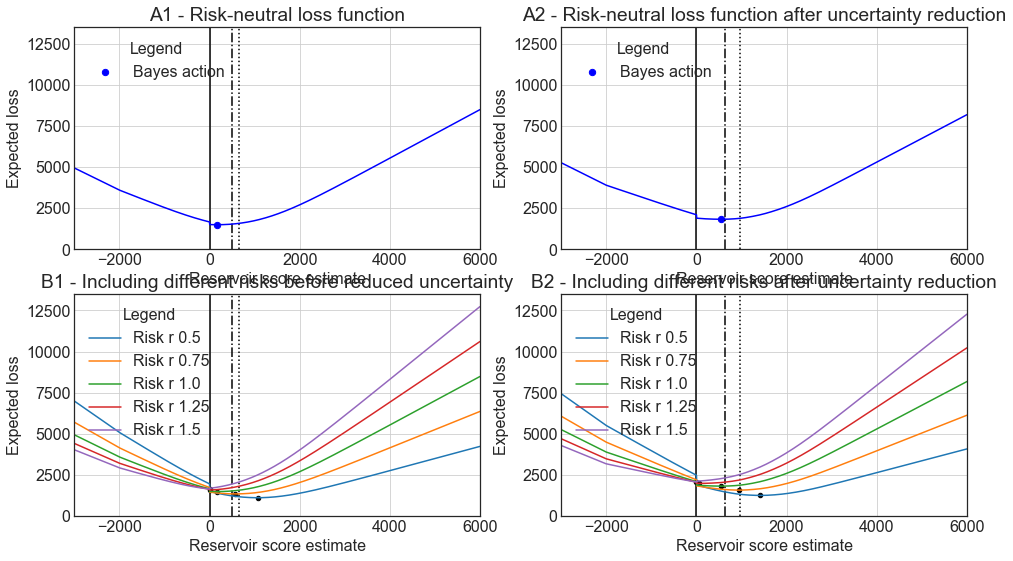

In [19]:
figsize(16, 9)
fig, ax = plt.subplots(2, 2)

# No reduced uncertainty, risk-neutral
expected_loss_sA1 = lambda estimate_s: res_score_loss4(estimate_s, res_score).mean()
loss = [expected_loss_sA1(e) for e in estimates_s]
_min_loss4 = sop.fmin(expected_loss_sA1, -40, disp = False)
ax[0,0].plot(estimates_s, loss, color = 'blue')
ax[0,0].scatter(_min_loss4, expected_loss_sA1(_min_loss4), s = 40, color = 'blue', label = "Bayes action")

# Reduced uncertainty, risk-neutral
expected_loss_sA2 = lambda estimate_s: res_score_loss4(estimate_s, res_score2).mean()
loss = [expected_loss_sA2(e) for e in estimates_s]
_min_loss4 = sop.fmin(expected_loss_sA2, -40, disp = False)
ax[0,1].plot(estimates_s, loss, color = 'blue')
ax[0,1].scatter(_min_loss4, expected_loss_sA2(_min_loss4), s = 40, color = 'blue', label = "Bayes action")

# No reduced uncertainty, different risks
BA_before = np.zeros_like(risks_s)
EL_before = np.zeros_like(risks_s)
expected_loss_sB1 = lambda estimate_s, risk_s: res_score_lossR(estimate_s, res_score, risk_s).mean()

counter = 0
for r in risks_s:
    loss = [expected_loss_sB1(e, r) for e in estimates_s]
    _min_score = sop.fmin(expected_loss_sB1, -40, args=(r,),disp = False)
    #print(_min_score)
    if _min_score < 0:
        _min_score = 0
    ax[1,0].plot(estimates_s, loss, label = "Risk r "+str(r))
    ax[1,0].scatter(_min_score, expected_loss_sB1(_min_score,r), s = 20, color = 'black')
    #lt.vlines(_min_results, 0, 0.02, color = 'black', linestyles="--")
    #print("Bayes action (minimum) at risk r %.2f: %.2f" % (r, _min_score))
    BA_before[counter] = _min_score
    EL_before[counter] = expected_loss_sB1(_min_score,r)
    counter += 1

# Reduced uncertainty, different risks
BA_after = np.zeros_like(risks_s)
EL_after = np.zeros_like(risks_s)
expected_loss_s = lambda estimate_s, risk_s: res_score_lossR(estimate_s, res_score2, risk_s).mean()

counter = 0
for r in risks_s:
    loss = [expected_loss_s(e, r) for e in estimates_s]
    _min_score = sop.fmin(expected_loss_s, -40, args=(r,),disp = False)
    if _min_score < 0:
        _min_score = 0
    ax[1,1].plot(estimates_s, loss, label = "Risk r "+str(r))
    ax[1,1].scatter(_min_score, expected_loss_s(_min_score,r), s = 20, color = 'black')
    #lt.vlines(_min_results, 0, 0.02, color = 'black', linestyles="--")
    #print("Bayes action (minimum) at risk r %.2f: %.2f" % (r, _min_score))
    BA_after[counter] = _min_score
    EL_after[counter] = expected_loss_s(_min_score,r)
    counter += 1

#A1 layout
ax[0,0].set_title("""A1 - Risk-neutral loss function""")    
ax[0,0].set_xlabel("Reservoir score estimate")
ax[0,0].set_ylabel("Expected loss")
ax[0,0].set_xlim(estimates_s[0], estimates_s[-1])
ax[0,0].set_ylim(0,1.1 * np.max(loss))
ax[0,0].grid()
ax[0,0].legend(loc="upper left", scatterpoints=1, title="Legend")
ax[0,0].vlines(0, 0, 1.1 * np.max(loss), label="zero score", linestyles="-")
ax[0,0].vlines(res_score.mean(), 0, 1.1 * np.max(loss), label="score mean", linestyles="-.")
ax[0,0].vlines(np.median(res_score), 0, 1.1 * np.max(loss), label="score median", linestyles=":")

#A2 layout
ax[0,1].set_title("""A2 - Risk-neutral loss function after uncertainty reduction""")    
ax[0,1].set_xlabel("Reservoir score estimate")
ax[0,1].set_ylabel("Expected loss")
ax[0,1].set_xlim(estimates_s[0], estimates_s[-1])
ax[0,1].set_ylim(0,1.1 * np.max(loss))
ax[0,1].grid()
ax[0,1].legend(loc="upper left", scatterpoints=1, title="Legend")
ax[0,1].vlines(0, 0, 1.1 * np.max(loss), label="zero score", linestyles="-")
ax[0,1].vlines(res_score2.mean(), 0, 1.1 * np.max(loss), label="score mean", linestyles="-.")
ax[0,1].vlines(np.median(res_score2), 0, 1.1 * np.max(loss), label="score median", linestyles=":")

#B1 layout
ax[1,0].set_title("""B1 - Including different risks before reduced uncertainty""")    
ax[1,0].legend(loc="upper left", scatterpoints=1, title="Legend")
ax[1,0].vlines(0, 0, 1.1 * np.max(loss), label="zero score", linestyles="-")
ax[1,0].vlines(res_score.mean(), 0, 1.1 * np.max(loss), label="posterior's mean", linestyles="-.")
ax[1,0].vlines(np.median(res_score), 0, 1.1 * np.max(loss), label="score median", linestyles=":")
ax[1,0].set_xlabel("Reservoir score estimate")
ax[1,0].set_ylabel("Expected loss")
ax[1,0].set_xlim(estimates_s[0], estimates_s[-1])
ax[1,0].set_ylim(0,1.1 * np.max(loss))
ax[1,0].grid()

#B2 layout
ax[1,1].set_title("""B2 - Including different risks after uncertainty reduction""")    
ax[1,1].legend(loc="upper left", scatterpoints=1, title="Legend")
ax[1,1].vlines(0, 0, 1.1 * np.max(loss), label="zero score", linestyles="-")
ax[1,1].vlines(res_score2.mean(), 0, 1.1 * np.max(loss), label="posterior's mean", linestyles="-.")
ax[1,1].vlines(np.median(res_score2), 0, 1.1 * np.max(loss), label="score median", linestyles=":")
ax[1,1].set_xlabel("Reservoir score estimate")
ax[1,1].set_ylabel("Expected loss")
ax[1,1].set_xlim(estimates_s[0], estimates_s[-1])
ax[1,1].set_ylim(0,1.1 * np.max(loss))
ax[1,1].grid()

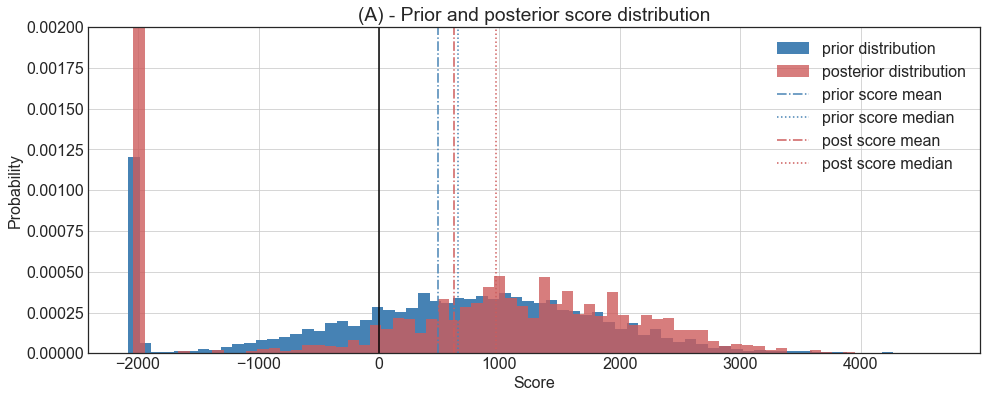

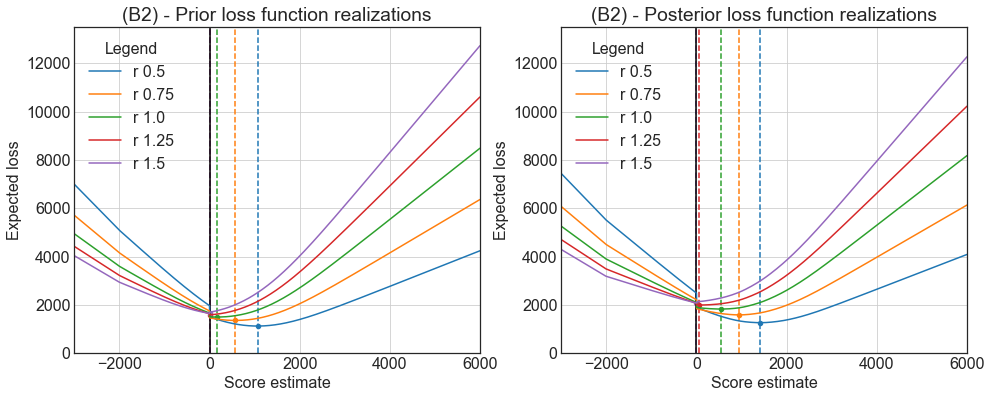

In [20]:
figsize(16, 6)

_hist1 = plt.hist(res_score, bins=70, normed=True, histtype="stepfilled",label="prior distribution", color = "steelblue")

_hist2 = plt.hist(res_score2, bins=70, normed=True, histtype="stepfilled",label="posterior distribution", color = "indianred", alpha = 0.8)

plt.vlines(res_score.mean(), 0, 0.002, label="prior score mean", linestyles="-.", color = "steelblue")
plt.vlines(np.median(res_score), 0, 0.002, label="prior score median", linestyles=":", color = "steelblue")

plt.vlines(res_score2.mean(), 0, 0.002, label="post score mean", linestyles="-.", color = "indianred")
plt.vlines(np.median(res_score2), 0, 0.002, label="post score median", linestyles=":", color = "indianred")

plt.vlines(0, 0, 0.002, linestyles="-")

plt.title("(A) - Prior and posterior score distribution")
plt.legend(loc="upper right");
plt.grid()
plt.ylim(0, 0.002)
plt.xlabel("Score")
plt.ylabel("Probability")

figsize(16, 6)
fig, ax = plt.subplots(1, 2)

# No reduced uncertainty, different risks
BA_before = np.zeros_like(risks_s)
EL_before = np.zeros_like(risks_s)
expected_loss_sB1 = lambda estimate_s, risk_s: res_score_lossR(estimate_s, res_score, risk_s).mean()

counter = 0
for r in risks_s:
    _color = next(ax[0]._get_lines.prop_cycler)
    loss = [expected_loss_sB1(e, r) for e in estimates_s]
    _min_score = sop.fmin(expected_loss_sB1, -40, args=(r,),disp = False)
    #print(_min_score)
    if _min_score < 0:
        _min_score = 0
    ax[0].plot(estimates_s, loss, label = "r "+str(r), color = _color['color'])
    ax[0].scatter(_min_score, expected_loss_sB1(_min_score,r), s = 20, color = _color['color'])
    ax[0].vlines(_min_score, 0, 20000, color=_color['color'], linestyles="--")
    #lt.vlines(_min_results, 0, 0.02, color = 'black', linestyles="--")
    #print("Bayes action (minimum) at risk r %.2f: %.2f" % (r, _min_score))
    BA_before[counter] = _min_score
    EL_before[counter] = expected_loss_sB1(_min_score,r)
    counter += 1

# Reduced uncertainty, different risks
BA_after = np.zeros_like(risks_s)
EL_after = np.zeros_like(risks_s)
expected_loss_s = lambda estimate_s, risk_s: res_score_lossR(estimate_s, res_score2, risk_s).mean()

counter = 0
for r in risks_s:
    _color = next(ax[1]._get_lines.prop_cycler)
    loss = [expected_loss_s(e, r) for e in estimates_s]
    _min_score = sop.fmin(expected_loss_s, -40, args=(r,),disp = False)
    if _min_score < 0:
        _min_score = 0
    ax[1].plot(estimates_s, loss, label = "r "+str(r), color = _color['color'])
    ax[1].scatter(_min_score, expected_loss_s(_min_score,r), s = 20, color = _color['color'])
    ax[1].vlines(_min_score, 0, 20000, color=_color['color'], linestyles="--")
    #lt.vlines(_min_results, 0, 0.02, color = 'black', linestyles="--")
    #print("Bayes action (minimum) at risk r %.2f: %.2f" % (r, _min_score))
    BA_after[counter] = _min_score
    EL_after[counter] = expected_loss_s(_min_score,r)
    counter += 1

#B1 layout
ax[0].set_title("""(B2) - Prior loss function realizations""")    
ax[0].legend(loc="upper left", scatterpoints=1, title="Legend")
ax[0].vlines(0, 0, 1.1 * np.max(loss), label="zero score", linestyles="-")
#ax[0].vlines(res_score.mean(), 0, 1.1 * np.max(loss), label="posterior's mean", linestyles="-.")
#ax[0].vlines(np.median(res_score), 0, 1.1 * np.max(loss), label="score median", linestyles=":")
ax[0].set_xlabel("Score estimate")
ax[0].set_ylabel("Expected loss")
ax[0].set_xlim(estimates_s[0], estimates_s[-1])
ax[0].set_ylim(0,1.1 * np.max(loss))
ax[0].grid()

#B2 layout
ax[1].set_title("""(B2) - Posterior loss function realizations""")    
ax[1].legend(loc="upper left", scatterpoints=1, title="Legend")
ax[1].vlines(0, 0, 1.1 * np.max(loss), label="zero score", linestyles="-")
#ax[1].vlines(res_score2.mean(), 0, 1.1 * np.max(loss), label="posterior's mean", linestyles="-.")
#ax[1].vlines(np.median(res_score2), 0, 1.1 * np.max(loss), label="score median", linestyles=":")
ax[1].set_xlabel("Score estimate")
ax[1].set_ylabel("Expected loss")
ax[1].set_xlim(estimates_s[0], estimates_s[-1])
ax[1].set_ylim(0,1.1 * np.max(loss))
ax[1].grid()

In [21]:
BA_diff = BA_after - BA_before
EL_diff = EL_after - EL_before

In [22]:
counter = 0
for r in risks_s:
    print("Bayes action shift due to uncertainty reduction for r %.2f: %.2f --- \
    Change in expected loss = %.2f" % (r, BA_diff[counter], EL_diff[counter]))
    counter += 1

Bayes action shift due to uncertainty reduction for r 0.50: 345.33 ---     Change in expected loss = 139.42
Bayes action shift due to uncertainty reduction for r 0.75: 376.31 ---     Change in expected loss = 229.22
Bayes action shift due to uncertainty reduction for r 1.00: 378.75 ---     Change in expected loss = 329.72
Bayes action shift due to uncertainty reduction for r 1.25: 62.73 ---     Change in expected loss = 406.66
Bayes action shift due to uncertainty reduction for r 1.50: 0.00 ---     Change in expected loss = 427.93


In [23]:
modelV2 = pm.Model([true_vol, res_thickness, layer_thickness1, layer_thickness2, res_top, res_bottom, seal_top])

MV2 = pm.MCMC(modelV2)
MV2.sample(iter=10000, burn=1000)

 [-----------------100%-----------------] 10000 of 10000 complete in 1.4 sec

In [24]:
res_vol2 = MV2.trace("true_vol")[:]

Mean of prior distribution: 1240553.68686
Mean of posterior distribution: 1295215.05808
Median of prior distribution: 1333534.33673
Median of posterior distribution: 1521963.24116


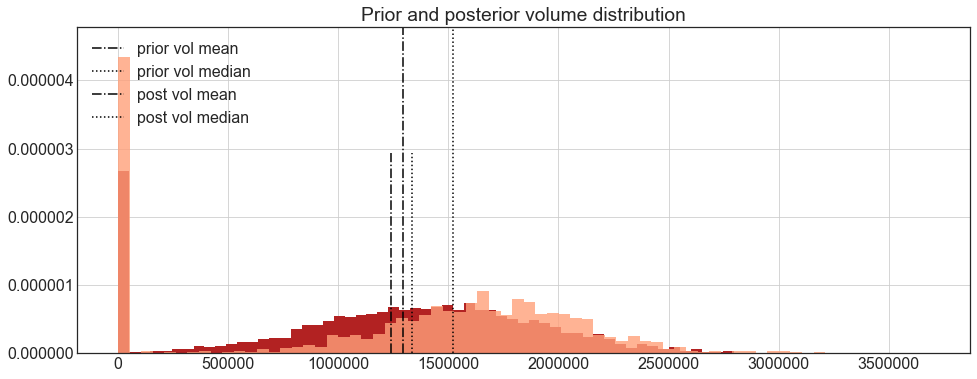

In [25]:
###Comparative figure VOLUME of score before and after updating
figsize(16, 6)

_hist = plt.hist(res_vol1, bins=70, normed=True, histtype="stepfilled", color = "firebrick")
plt.vlines(res_vol1.mean(), 0, 1.1 * np.max(_hist[0]), label="prior vol mean", linestyles="-.")
plt.vlines(np.median(res_vol1), 0, 1.1 * np.max(_hist[0]), label="prior vol median", linestyles=":")

_hist = plt.hist(res_vol2, bins=70, normed=True, histtype="stepfilled", color = "lightsalmon", alpha = 0.8)
plt.vlines(res_vol2.mean(), 0, 1.1 * np.max(_hist[0]), label="post vol mean", linestyles="-.")
plt.vlines(np.median(res_vol2), 0, 1.1 * np.max(_hist[0]), label="post vol median", linestyles=":")
#plt.vlines(0, 0, 1.1 * np.max(_hist[0]), label="zero score", linestyles="-")
plt.title("Prior and posterior volume distribution")
plt.legend(loc="upper left");
plt.grid()
plt.ylim(0, 1.1 * np.max(_hist[0]))

#negative_cases1 = (res_score<0).sum()/5000
#negative_cases2 = (res_score2<0).sum()/9000
#print("Portion of cases in which the score is negative prior:",negative_cases1)
#print("Portion of cases in which the score is negative post:",negative_cases2)
print("Mean of prior distribution:",res_vol1.mean())
print("Mean of posterior distribution:",res_vol2.mean())
print("Median of prior distribution:",np.median(res_vol1))
print("Median of posterior distribution:",np.median(res_vol2))

In [26]:
#maybe add another uncertain parameter: possible leak due to fault somewhere below seal!
#uncertain point position of fault
#uncertain if leaking (zero-one classification?)